In [1]:
import logging, sys
from typing import List, Callable, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc  
from sklearn.decomposition import PCA 
from IPython.display import display, Latex

from pynamics import downsample, downsample_split, avg_over
from pynamics.utils import np_cache, eigsort
from pynamics.systems import DoubleWell
from randnn.plotting import *
from pytransfer.transfer_operator import *

rc('text', usetex=True)
# logging.basicConfig(level=logging.INFO)
np.set_printoptions(threshold=100)

# Applying the transfer operator approach

### 1. Coarse-graining in space:

#### Clustering

We run an explicit coarse-graining step by clustering the embedding space.

### 2. Coarse-graining in time: 

#### Downsampling
We are interested in the long-term behavior of the system (and have finitely powerful computers), so we downsample the trajectory, discarding many intermediate timesteps.

#### Delay embedding
To achieve a near-memory-less (Markovian) definition of state, we stack delayed copies of measurements within a short time window.

# Parameters

In [70]:
# ------------------------
# DOUBLE WELL PARAMETERS
# ------------------------

# Main parameters:
# For clear timescale separation, try Beta = 5. 
# For higher values, you start to run into the problem of well-lock
BETA =  2
IS_OVERDAMPED = True

# The following parameters influence temporal resolution and trajectory duration
TIMESTEP = 0.01 # 0.01 
DOWNSAMPLE_RATE = 1 # 10

TIMESPAN = 100000 # 100000
N_STEPS = int(TIMESPAN // TIMESTEP)
N_BURNIN_STEPS = 1000 

N_CLUSTERS = 200 #1225
TRANSITION_TIMESCALE = 1 # This is the number of timesteps to take before counting a transition from one cell to the next
# -----------------------
# PLOTTING PARAMETERS
# ------------------------

EIGENVALUE_RANGE = [1, 10]

In [71]:
double_well = DoubleWell(beta=BETA, timestep=TIMESTEP, is_overdamped=True)
time_series = double_well.run(n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS)[::DOWNSAMPLE_RATE]

transfer_operator = TransferOperator(labeling_method="uniform", n_clusters=N_CLUSTERS)
transfer_operator.fit(verbose=True, time_series=time_series, n_future_timesteps=TRANSITION_TIMESCALE)

Generating samples: 100%|██████████| 9999999/9999999 [04:07<00:00, 40336.26it/s]


<ipython-input-72-9d4c3108cf69>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  plt.hlines(np.array([cluster_size, inter_well_width, well_width]).T, 0.1, times[-1])
/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

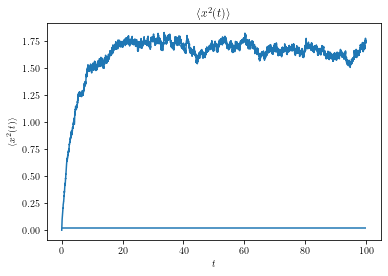

In [72]:
min_x = np.amin(time_series, axis=0)
max_x = np.amax(time_series, axis=0)
cluster_size = (max_x-min_x) / N_CLUSTERS 

well_width = max_x - min_x / 2
inter_well_width = 2

SEGMENT_LENGTH = 10000
times = np.arange(SEGMENT_LENGTH)* TIMESTEP
n_segments = N_STEPS // SEGMENT_LENGTH
distances_with_time = np.zeros((1, SEGMENT_LENGTH))

for i in range(n_segments):
    I = SEGMENT_LENGTH * i
    distances_with_time += np.square(time_series[I:I+SEGMENT_LENGTH].T - (time_series[I] * np.ones(SEGMENT_LENGTH)))
    
distances_with_time /= n_segments
plt.plot(times,distances_with_time.T)
plt.title("$\langle x^2(t)\\rangle$")
plt.ylabel("$\langle x^2(t)\\rangle$")
plt.xlabel("$t$")
plt.hlines(np.array([cluster_size, inter_well_width, well_width]).T, 0.1, times[-1])


In [ ]:
plt.plot(times[:100],distances_with_time.T[:100])
plt.title("$\langle x^2(t)\\rangle$")
plt.ylabel("$\langle x^2(t)\\rangle$")
plt.xlabel("$t$")
plt.hlines(np.array([cluster_size, inter_well_width, well_width]).T, 0, times[100])

/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/plotting/double_well.py:89: ComplexWarning: Casting complex values to real discards the imaginary part
  forward_entropies[i] = matrix.forward_entropy
/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/plotting/double_well.py:90: ComplexWarning: Casting complex values to real discards the imaginary part
  reverse_entropies[i] = matrix.reverse_entropy
/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/plotting/double_well.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  entropy_productions[i] = matrix.entropy_production


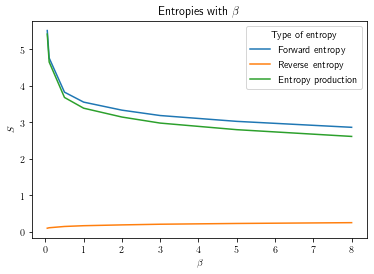

In [3]:
RATE = 1
TIMESTEP = 0.01
BETAS = [0.05, 0.1, 0.5, 1, 2, 3, 5, 8]
TIMESTEP = 0.01
N_STEPS = 1000000
plot_entropies_with_betas(BETAS, RATE, TIMESTEP, N_STEPS, N_BURNIN_STEPS, N_CLUSTERS)

# Generating data — Overdamped

In [5]:
display(Latex(f"Your relative height is $KT/h={1./double_well.rel_barrier_height}$"))

<IPython.core.display.Latex object>

## Equilibrium

Let's establish that we've actually settled into equilibrium. 

### Boltzmann distribution

The first check is that the Boltzmann distributions appear qualitatively similar. If this is off, we already know we need to go back to the drawing board.


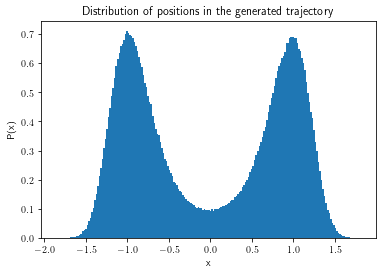

/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6658: ComplexWarning: Casting complex values to real discards the imaginary part
  tops = np.array(tops, float)  # causes problems later if it's an int


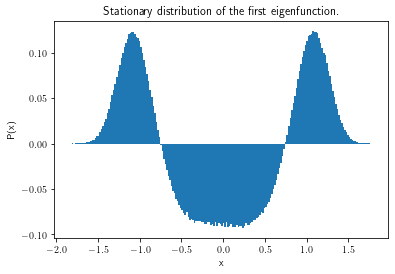

/Users/Jesse/.local/share/virtualenvs/randnn-PaBUC3Au/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6658: ComplexWarning: Casting complex values to real discards the imaginary part
  tops = np.array(tops, float)  # causes problems later if it's an int


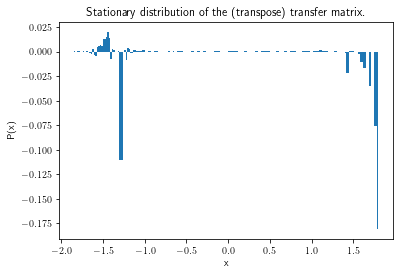

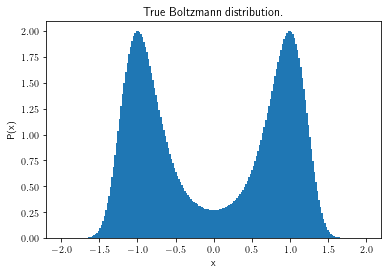

In [61]:
dX = 0.01
positions = np.array([np.arange(-2, 2, dX)]).T

# We compare the Boltzmann distribution directly from data...

plt.hist(time_series, density=True, bins=N_CLUSTERS)
plt.ylabel("P(x)")
plt.xlabel("x")

plt.title("Distribution of positions in the generated trajectory")
plt.show()

# ...with the distribution from the transfer matrix...

cluster_centers = transfer_operator.cluster_centers
min_x = np.amin(time_series, axis=0)
max_x = np.amax(time_series, axis=0)
step = (max_x-min_x) / transfer_operator.invariant_dist.size

plt.hist(cluster_centers, weights=transfer_operator.eigvecs[:,2], bins=N_CLUSTERS)
plt.ylabel("P(x)")
plt.xlabel("x")
plt.title("Stationary distribution of the first eigenfunction.")
plt.show()

cluster_centers = transfer_operator.cluster_centers
min_x = np.amin(time_series, axis=0)
max_x = np.amax(time_series, axis=0)
step = (max_x-min_x) / transfer_operator.invariant_dist.size

plt.hist(cluster_centers, weights=transfer_operator.eigvecs[0,:], bins=N_CLUSTERS)
plt.ylabel("P(x)")
plt.xlabel("x")
plt.title("Stationary distribution of the (transpose) transfer matrix.")
plt.show()


# eigsort(transfer_operator.forward_matrix.T, eig_method="np")

# ... and against the theoretical distribution

weights = double_well.boltzmann_weights(positions)
plt.hist(positions, weights=weights, bins=N_CLUSTERS)
plt.ylabel("P(x)")
plt.xlabel("x")

plt.title("True Boltzmann distribution.")
plt.show()

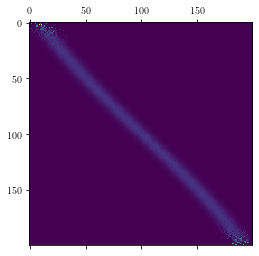

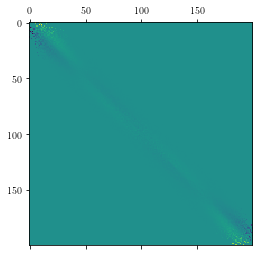

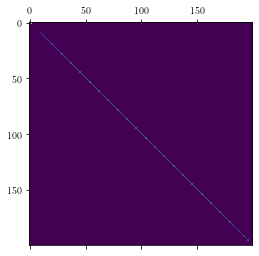

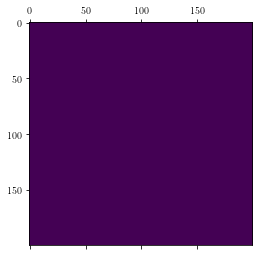

In [7]:
plt.matshow(transfer_operator.forward_matrix)
plt.matshow((transfer_operator.forward_matrix - transfer_operator.forward_matrix.T))
plt.matshow(transfer_operator.reverse_matrix)
plt.matshow(transfer_operator.reverse_matrix - transfer_operator.reverse_matrix.T)

### Energy distribution

For a more quantitative check, we can compare the observed energy distribution to the theoretical distribution and confirm that the equipartition theorem holds (i.e. that each dof has, on average, an energy $kT/2$). 

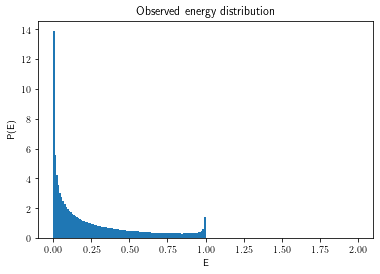

NameError: name 'stable_dist' is not defined

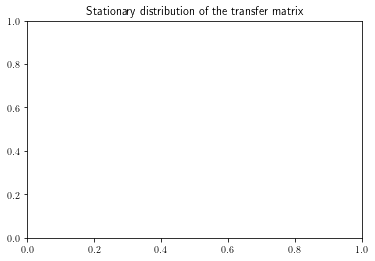

In [8]:
# We compare the energy distribution observed directly in data...
ts_energies = double_well.energy(time_series) 
plt.title("Observed energy distribution")
plt.hist(ts_energies, density=True, bins=N_CLUSTERS, range=[0, 2])
plt.ylabel("P(E)")
plt.xlabel("E")
plt.show()

ts_avg_energy = np.mean(ts_energies)

# ...with the distribution from the transfer matrix...
tm_energies = double_well.energy(cluster_centers)
plt.title("Stationary distribution of the transfer matrix")
plt.hist(tm_energies, density=True, bins=N_CLUSTERS, weights=stable_dist, range=[0, 2])
plt.ylabel("P(E)")
plt.xlabel("E")
plt.show()

tm_avg_energy = np.mean(stable_dist @ tm_energies)

# ...and against the theoretical distribution.
probs = double_well.boltzmann_probs(cluster_centers)
theoretical_energies = double_well.energy(cluster_centers) 

plt.title("Theoretical energy distribution")
plt.hist(theoretical_energies, density=True, bins=N_CLUSTERS, weights=probs, range=[0, 2])
plt.ylabel("P(E)")
plt.xlabel("E")
plt.show()

theoretical_avg_energy = np.mean(probs @ theoretical_energies)



### Energy

It would have been nice if we could have applied the equipartition theorem to compare the average energy levels to observed (in which case we would expect $\langle E\rangle=KT/2$).

However, in the overdamped limit, we don't have quartic dofs, so we have to compute the expected energy exactly (numerically).

$$\langle E\rangle = \int_{-\infty}^{\infty}V(x) P(x)dx ,$$
where $V(x)=-x^2+x^4$, $P(x)=e^{-\beta V(x)}/Z$, and $Z=\int_{-\infty}^{\infty} e^{-\beta V(x)}dx$.


In [ ]:
# And compare the average energy.
print(f"The average energy of the particle from the time series is {ts_avg_energy}")
print(f"The average energy of the particle from the transfer operator is {tm_avg_energy}")
print(f"The theoretical energy of the particle is (check) {theoretical_avg_energy}")
print(f"The theoretical energy is (as given by the numerical integration of above): {double_well.avg_energy}")


In [ ]:
betas =[0.05,0.1,0.5, 1, 2, 3, 5, 8]
measured_energies = np.zeros(len(betas))
matrix_energies = np.zeros(len(betas))
theoretical_energies= np.zeros(len(betas))

TIMESTEP = 0.01
N_STEPS = 1000000
for i, beta in enumerate(betas):
    dw = DoubleWell(beta=beta, timestep=TIMESTEP, is_overdamped=True)
    traj = dw.run(n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS)
    matrix = TransferOperator(labeling_method="uniform", n_clusters=N_CLUSTERS)
    matrix.fit(traj, n_future_timesteps=TRANSITION_TIMESCALE,k=50)
    
    cluster_centers = matrix.cluster_centers
    cluster_energies = dw.energy(cluster_centers)
    stable_dist = np.abs(matrix.eigvecs[:,0])/ np.sum(np.abs(matrix.eigvecs[:, 0]))
    
    measured_energies[i] = np.mean(dw.energy(traj))
    matrix_energies[i] = np.mean(stable_dist @ cluster_energies)
    theoretical_energies[i] = dw.avg_energy

plt.title("$\langle E \\rangle$ with $\\beta$ ($\\tau=1$)")
plt.yscale('log')
plt.xscale('log')

plt.plot(betas, theoretical_energies, label="Numerical solution")
plt.plot(betas, measured_energies, label="Directly from data")
plt.plot(betas, matrix_energies, label="Transfer Matrix")
plt.legend(title="Source")
plt.xlabel("$\\beta$")
plt.ylabel("$\langle E \\rangle$")
plt.show()

plt.title("Error in $\langle E \\rangle$ with $\\beta$ ($\\tau=1$)")
traj_errors = np.abs(measured_energies - theoretical_energies)/theoretical_energies * 100
matrix_errors = np.abs(matrix_energies - theoretical_energies)/theoretical_energies * 100

plt.plot(betas, traj_errors, label="From data")
plt.plot(betas, matrix_errors, label="Transfer matrix")
plt.legend(title="Source")
plt.xlabel("$\\beta$")
plt.ylabel("Relative error (\%)") 
plt.show()


### Convergence

We make sure we've included enough burn in samples and that the running average energy isn't fluctuating too wildly.

In [ ]:
# running_avg_energy = double_well.running_avg(
#   time_series, 
#     double_well.energy,
#     window_size=5000,
#     step_size=1000,
#     verbose=True
# )

# plt.plot(running_avg_energy)


### Eigenvalue spectrum & Timescale separation

In [ ]:
print("FROM KRAMER'S RATE THEORY")
print("\n\tSTARTING AT X=0")
print(f"\tFirst Passage Time (-inf to 0) {double_well.first_passage_time(-1)}")

print('\n\tAVG OVER THE IVL')
print(f"\tFirst Passage Time (-inf to 0) {double_well.avg_first_passage_time()}")

print("\nFROM TRAJECTORIES DIRECTLY\n")
print(f"\tFirst Passage Time (-inf to 0) {double_well.measure_first_passage_time(time_series)* DOWNSAMPLE_RATE}")

print("\nFROM TRANSFER MATRIX\n")
# print(f"Max eigval {eigvals[1]} and inverse {1./eigvals[1]}")
print(f"\tMax timescale {double_well.get_timescale(eigvals[1], multiplier=DOWNSAMPLE_RATE)}")

#transition_times= np.zeros(1000)

#for i in range(1, 1001):
#    transition_times[i-1] = double_well.transition_time(time_series, i)

#plt.plot(transition_times)

In [ ]:
betas =[0.05,0.1,0.5, 1, 2, 3, 5, 8]
theoretical_times = np.zeros(len(betas))
trajectory_times =  np.zeros(len(betas))
matrix_times =  np.zeros(len(betas))

TIMESTEP = 0.01
N_STEPS = 1000000
for i, beta in enumerate(betas):
    dw = DoubleWell(beta=beta, timestep=TIMESTEP, is_overdamped=True)
    traj = dw.run(n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS)
    matrix = TransferOperator(labeling_method="uniform", n_clusters=N_CLUSTERS)
    matrix.fit(traj, n_future_timesteps=TRANSITION_TIMESCALE,k=50)
    theoretical_times[i] = dw.avg_first_passage_time()
    trajectory_times[i]=dw.measure_first_passage_time(traj)
    matrix_times[i]=dw.get_timescale(matrix.eigvals[1])
    #print(f"First Passage Time\t(-inf to 0) {theoretical_times[i]}")
    #print(f"Trajectory Passage Time\t(-inf to 0) {trajectory_times[i]}")
    # print(f"Max timescale\t\t{matrix_times[i]}")

plt.title("Timescale scaling with $\\beta$ ($\\tau=1$)")
plt.yscale('log')
plt.plot(betas, theoretical_times, label="Kramers")
plt.plot(betas, trajectory_times, label="Directly from data")
plt.plot(betas, matrix_times, label="Transfer Matrix")
plt.legend(title="Source")
plt.xlabel("$\\beta$")
plt.ylabel("$t_{imp}$")
plt.show()

plt.title("Error with $\\beta$ ($\\tau=1$)")
traj_errors = np.abs(trajectory_times - theoretical_times)/theoretical_times * 100
matrix_errors = np.abs(matrix_times - theoretical_times)/theoretical_times * 100

plt.plot(betas[1:], traj_errors[1:], label="From data")
plt.plot(betas[1:], matrix_errors[1:], label="Transfer matrix")
plt.legend(title="Source")
plt.xlabel("$\\beta$")
plt.ylabel("Relative error (\%)") 
plt.show()



In [ ]:
timesteps = [0.05, 0.01, 0.001, 0.0001]
theoretical_times = np.zeros(len(timesteps))
trajectory_times =  np.zeros(len(timesteps))
matrix_times =  np.zeros(len(timesteps))

BETA = 1
N_STEPS = 1000000
for i, timestep in enumerate(timesteps):
    dw = DoubleWell(beta=BETA, timestep=timestep, is_overdamped=True)
    traj = dw.run(n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS)
    matrix = TransferOperator(labeling_method="uniform", n_clusters=N_CLUSTERS)
    matrix.fit(traj, n_future_timesteps=TRANSITION_TIMESCALE,k=50)
    theoretical_times[i] = dw.avg_first_passage_time()
    trajectory_times[i]=dw.measure_first_passage_time(traj)
    matrix_times[i]=dw.get_timescale(matrix.eigvals[1])

plt.title(f"Timescale scaling with $\Delta t$ ($\\beta = {BETA}$)")
plt.xscale('log')
plt.plot(timesteps, theoretical_times, label="Kramers")
plt.plot(timesteps, trajectory_times, label="Directly from data")
plt.plot(timesteps, matrix_times, label="Transfer Matrix")
plt.legend(title="Source")
plt.xlabel("$\Delta t$")
plt.ylabel("$t_{imp}$")
plt.show()


In [ ]:
timesteps = [0.05, 0.01, 0.001, 0.0001]
theoretical_times = np.zeros(len(timesteps))
trajectory_times =  np.zeros(len(timesteps))
matrix_times =  np.zeros(len(timesteps))

BETA = 5
N_STEPS = 1000000
for i, timestep in enumerate(timesteps):
    dw = DoubleWell(beta=BETA, timestep=timestep, is_overdamped=True)
    traj = dw.run(n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS)
    matrix = TransferOperator(labeling_method="uniform", n_clusters=N_CLUSTERS)
    matrix.fit(traj, n_future_timesteps=TRANSITION_TIMESCALE,k=50)
    theoretical_times[i] = dw.avg_first_passage_time()
    trajectory_times[i]=dw.measure_first_passage_time(traj)
    matrix_times[i]=dw.get_timescale(matrix.eigvals[1])
    print(f"First Passage Time\t(-inf to 0) {theoretical_times[i]}")
    print(f"Trajectory Passage Time\t(-inf to 0) {trajectory_times[i]}")
    print(f"Max timescale\t\t{matrix_times[i]}")

plt.title(f"Timescale scaling with $\Delta t$ ($\\beta = {BETA}$)")
plt.xscale('log')
plt.plot(timesteps, theoretical_times, label="Kramers")
plt.plot(timesteps, trajectory_times, label="Directly from data")
plt.plot(timesteps, matrix_times, label="Transfer Matrix")
plt.legend(title="Source")
plt.xlabel("$\Delta t$")
plt.ylabel("$t_{imp}$")
plt.show()

In [ ]:
RATE = 1
TIMESTEP = 0.01
BETAS = [0.05, 0.1, 0.5, 1, 2, 3, 5, 8]
TIMESTEP = 0.01
N_STEPS = 1000000
plot_eigval_spectra_with_betas(BETAS, RATE, TIMESTEP, N_STEPS, N_BURNIN_STEPS, N_CLUSTERS)

In [ ]:
RATES = [1, 10, 50, 100, 200]
BETA = 0.1
TIMESTEP = 0.01
N_STEPS = 1000000
plot_eigval_spectra_with_rates(RATES, BETA, TIMESTEP, N_STEPS, N_BURNIN_STEPS, N_CLUSTERS)

In [ ]:
RATES = [1, 10, 50, 100, 200]
BETA = 5
TIMESTEP = 0.01
N_STEPS = 1000000
plot_eigval_spectra_with_rates(RATES, BETA, TIMESTEP, N_STEPS, N_BURNIN_STEPS, N_CLUSTERS)

In [ ]:
RATES = [1, 10, 50, 100, 200]
BETA = 2
TIMESTEP = 0.01
N_STEPS = 1000000
plot_eigval_spectra_with_rates(RATES, BETA, TIMESTEP, N_STEPS, N_BURNIN_STEPS, N_CLUSTERS)


In [ ]:
RATES = [1, 10, 50, 100, 200]
BETA = 2
TIMESTEP = 0.01
N_STEPS = 100000
   
plot_eigval_spectra_with_downsampling(RATES, BETA, TIMESTEP, N_STEPS, N_BURNIN_STEPS, N_CLUSTERS)

### Timescale convergence

In [ ]:
raise ValueError
N_CLUSTERS_LIST = [10, 100, 400]
TRANSITION_TIMES = range(1, 20, 4)

plot_t_imp_scaling(time_series, 
                   1, 
                   n_clusters_list=N_CLUSTERS_LIST, 
                   transition_times=TRANSITION_TIMES,
                   timestep=TIMESTEP/DOWNSAMPLE_RATE)

In [ ]:
cluster_centers = transfer_operator.cluster_centers
eigvals, eigvecs = eigsort(transfer_operator.forward_matrix.T, eig_method="np")
eigvals_b, eigvecs_b = eigsort(transfer_operator.balanced_matrix.T, eig_method="np")

plt.hist(cluster_centers,weights=eigvecs[:, 0], bins=100, density=True)
plt.show()
plt.hist(cluster_centers,weights=eigvecs_b[:, 1], bins=100, density=True)
plt.show()

In [ ]:
RATES = [1, 2, 5, 5000, 10000, 20000]
BETA = 5
TIMESTEP = 0.0001
N_STEPS = 10000000
display(Latex(f"$\Delta t = {TIMESTEP}$"))
plot_eigval_spectra_with_rates(RATES, BETA, TIMESTEP, N_STEPS, N_BURNIN_STEPS, 100, inset_pos=(.6, .3))
plot_eigval_spectra_with_rates(RATES, BETA, TIMESTEP, N_STEPS, N_BURNIN_STEPS, 200, inset_pos=(.6, .3))
plot_eigval_spectra_with_rates(RATES, BETA, TIMESTEP, N_STEPS, N_BURNIN_STEPS, 500, inset_pos=(.6, .3))

<IPython.core.display.Latex object>

Generating samples: 100%|██████████| 10000000/10000000 [04:04<00:00, 40820.44it/s]
<ipython-input-73-025565cbd0b0>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[i,:] = matrix.eigvals[1:1+N_EIGVALS]


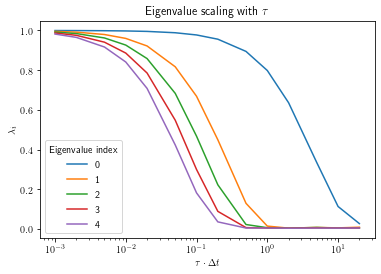

In [73]:
RATES = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000,20000]
BETA = 2
TIMESTEP = 0.001
N_STEPS = 10000000
display(Latex(f"\Delta t = {TIMESTEP}"))

N_EIGVALS = 5
eigenvalues = np.zeros((len(RATES), N_EIGVALS))

for i, rate in enumerate(RATES):
    dw = DoubleWell(beta=BETA, timestep=TIMESTEP, is_overdamped=True)
    traj = dw.run(n_steps=N_STEPS, n_burn_in=N_BURNIN_STEPS)
    matrix = TransferOperator(labeling_method="uniform", n_clusters=N_CLUSTERS)
    matrix.fit(traj, n_future_timesteps=rate,k=50)
    eigenvalues[i,:] = matrix.eigvals[1:1+N_EIGVALS]
    
for i in range(N_EIGVALS):
    plt.plot(np.array(RATES)* TIMESTEP, eigenvalues[:,i], label=i)
    
plt.title(f"Eigenvalue scaling with $\\tau$")
plt.xscale("log")
plt.legend(title="Eigenvalue index")
plt.xlabel("$\\tau \cdot \Delta t$")
plt.ylabel("$\lambda_i$")
plt.show()
